In [1]:
import os
import math
import pickle
import tqdm
from multiprocessing import Pool

import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from src.utils import preprocess_backtest_data
from src.backtest import aggregate_weights, backtest, backtest_baseline

device = torch.device('cuda:0')

In [2]:
sns.set()
sns.set_style(style='white')

In [3]:
backtest_start = '2019-11'
backtest_end = '2024-11'
trading_cost = 0.004
lagging = 2

In [4]:
universes = ['universe1', 'universe2']
ports = ['MaxSortino', 'OneHot']
models = ['Mamba', 'TRF', 'LSTM']
optimizers = ['sophia']

In [5]:
universe1_yearmons, universe1_data = preprocess_backtest_data(f'data/universe1.csv')
universe2_yearmons, universe2_data = preprocess_backtest_data(f'data/universe2.csv')

In [14]:
directory = 'result/'
for universe in universes:
    file_name = universe + '_1000_all_weights'
    if os.path.exists(directory + file_name + '.pkl'):
        with open(directory + file_name + '.pkl', 'rb') as f:
            object = pickle.load(f)
        exec(file_name + ' = object')
    else:
        print(file_name)

In [15]:
num_samples = [2 ** x for x in range(7)]

In [23]:
all_weights = universe1_1000_all_weights
yearmons = universe1_yearmons
data = universe1_data

np.random.seed(42)

num_sample = 1000
num_model = len(all_weights)

def simulate(num_weight):
    np.random.seed(np.random.randint(0, high = 1 << 31))

    n = min(math.comb(num_model, num_weight), num_sample)

    results = []
    for _ in range(n):
        choice = np.random.choice(range(num_model), num_weight)
        weights = aggregate_weights(yearmons, data, [all_weights[x] for x in choice], backtest_start)
        results.append(backtest(yearmons, data, weights, backtest_start, trading_cost, lagging))

    return results
    

In [24]:
with Pool(len(num_samples)) as p:
    universe1_all_backtest = p.map(simulate, num_samples)

In [25]:
all_weights = universe2_1000_all_weights
yearmons = universe2_yearmons
data = universe2_data

np.random.seed(42)

num_sample = 1000
num_model = len(all_weights)

common_index = all_weights[0].index.map(lambda x: data.resample('M').ffill().loc[x].index[-1])

def simulate(num_weight):
    np.random.seed(np.random.randint(0, high = 1 << 31))

    n = min(math.comb(num_model, num_weight), num_sample)

    results = []
    for _ in range(n):
        choice = np.random.choice(range(num_model), num_weight)

        weights = aggregate_weights(yearmons, data, [all_weights[x] for x in choice], backtest_start)

        results.append(backtest(yearmons, data, weights, backtest_start, trading_cost, lagging))

    return results
    

In [26]:
with Pool(len(num_samples)) as p:
    universe2_all_backtest = p.map(simulate, num_samples)

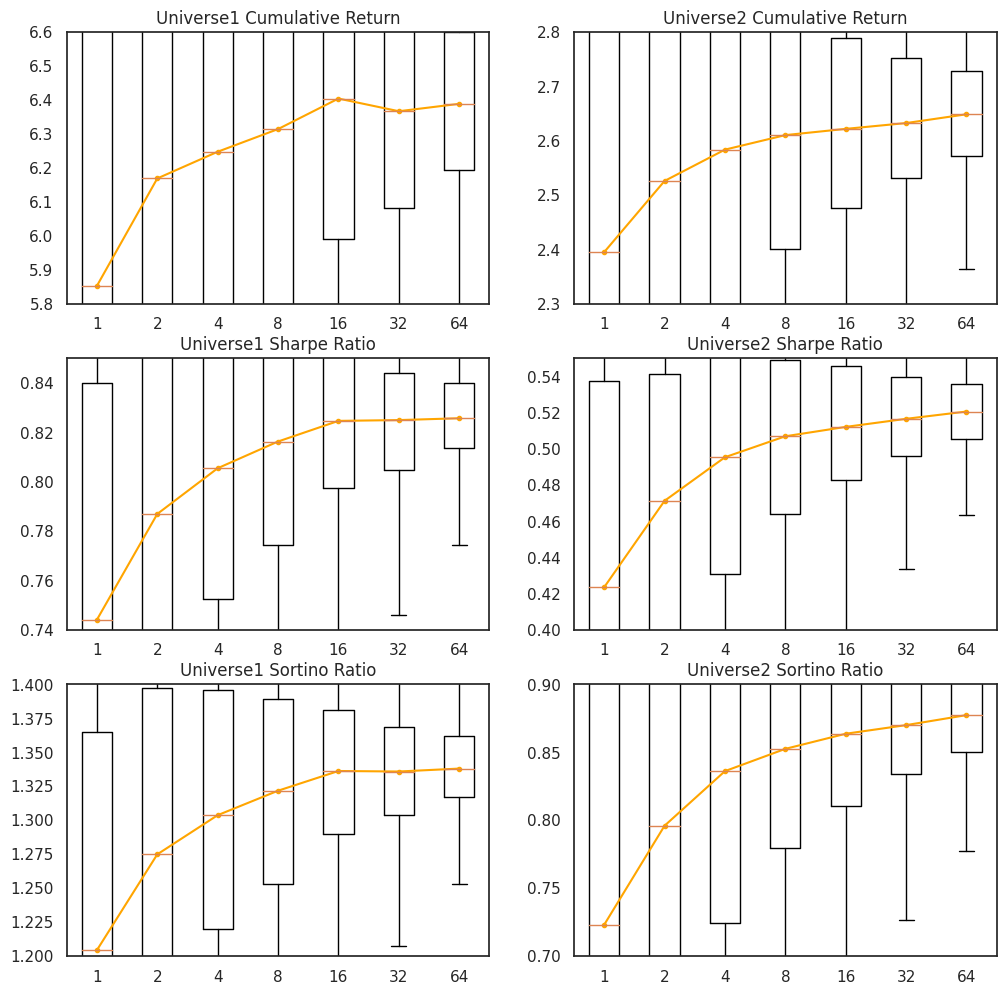

In [30]:
universe1_ensemble_data = [pd.concat(x, axis = 1).apply(np.exp).cumprod().iloc[-1].values for x in universe1_all_backtest]
universe2_ensemble_data = [pd.concat(x, axis = 1).apply(np.exp).cumprod().iloc[-1].values for x in universe2_all_backtest]

markersize = 3


fig = plt.figure(figsize = (12, 12))


ax = fig.add_subplot(3, 2, 1)

data = universe1_ensemble_data

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('Universe1 Cumulative Return')
ax.set_ylim(5.8, 6.6)

ax = fig.add_subplot(3, 2, 2)

data = universe2_ensemble_data

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('Universe2 Cumulative Return')
ax.set_ylim(2.3, 2.8)

universe1_ensemble_data = [pd.concat(x, axis = 1).mean() / pd.concat(x, axis = 1).std() * np.sqrt(252) for x in universe1_all_backtest]
universe2_ensemble_data = [pd.concat(x, axis = 1).mean() / pd.concat(x, axis = 1).std() * np.sqrt(252) for x in universe2_all_backtest]

ax = fig.add_subplot(3, 2, 3)

data = universe1_ensemble_data

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('Universe1 Sharpe Ratio')
ax.set_ylim(0.74, 0.85)

ax = fig.add_subplot(3, 2, 4)

data = universe2_ensemble_data

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('Universe2 Sharpe Ratio')
ax.set_ylim(0.4, 0.55)

universe1_ensemble_data = [pd.concat(x, axis = 1).mean() / pd.concat(x, axis = 1).clip(upper=0).std() * np.sqrt(252) for x in universe1_all_backtest]
universe2_ensemble_data = [pd.concat(x, axis = 1).mean() / pd.concat(x, axis = 1).clip(upper=0).std() * np.sqrt(252) for x in universe2_all_backtest]

ax = fig.add_subplot(3, 2, 5)

data = universe1_ensemble_data

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('Universe1 Sortino Ratio')
ax.set_ylim(1.2, 1.4)

ax = fig.add_subplot(3, 2, 6)

data = universe2_ensemble_data

ax.boxplot(data, showfliers = False)
ax.plot(range(1, 8), [np.median(x) for x in data], marker='o', markersize = markersize, color = 'orange')
ax.set_xticklabels(num_samples)

ax.set_title('Universe2 Sortino Ratio')
ax.set_ylim(0.7, 0.9)

plt.show()